# Demodulation of 16-QAM Signals

In [1]:
import sys
sys.path.append('../my_module')

import sofamethods as sm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Input data preparation

In [3]:
mod_dict = np.array([
    [-3, 3], [-3, 1], [-3, -3], [-3, -1],
    [-1, 3], [-1, 1], [-1, -3], [-1, -1],
    [3, 3], [3, 1], [3, -3], [3, -1],
    [1, 3], [1, 1], [1, -3], [1, -1]
])

np.random.seed(0)
Ns = 10000
n = 16
y = np.random.randint(n, size=Ns)
syms_rx = mod_dict[y]

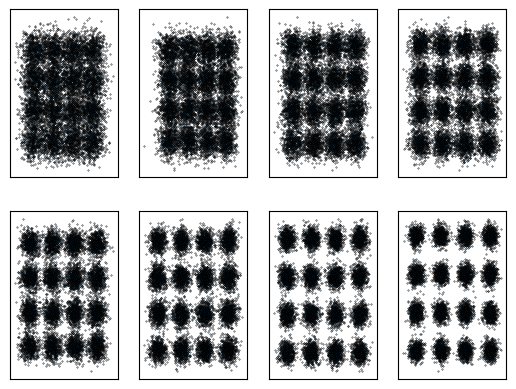

In [4]:
OSNR = np.arange(11, 19, 1)
X = []
for i in OSNR:
    X.append(np.transpose([sm.add_noise(syms_rx[:, 0], i), sm.add_noise(syms_rx[:, 1], i)]))
X = np.array(X)

for i in range(len(OSNR)):
    plt.subplot(2, 4, i+1)
    plt.scatter(X[i, :, 0], X[i, :, 1], s=0.1, edgecolors='black')
    plt.xticks(())
    plt.yticks(())
plt.show()

## Conventional demodulation

In [5]:
syms_dem = np.array([sm.demapper_sym(X[i, :, 0], X[i, :, 1]) for i in range(len(OSNR))])

ber_conv = []
for i in range(len(OSNR)):
    ber_conv.append(sm.bit_error_rate(y, syms_dem[i]))
    print("Complete iteration: ", i+1, "/", len(OSNR))

Complete iteration:  1 / 8
Complete iteration:  2 / 8
Complete iteration:  3 / 8
Complete iteration:  4 / 8
Complete iteration:  5 / 8
Complete iteration:  6 / 8
Complete iteration:  7 / 8
Complete iteration:  8 / 8


## KNN implementation

In [6]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
}

ber_knn = []
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    ber_knn.append(sm.bit_error_rate(y_test, y_pred))
    print("Complete iteration:", i+1, "/", len(OSNR), " with best params:", knn.best_params_)

Complete iteration: 1 / 8  with best params: {'n_neighbors': 15}
Complete iteration: 2 / 8  with best params: {'n_neighbors': 15}
Complete iteration: 3 / 8  with best params: {'n_neighbors': 15}
Complete iteration: 4 / 8  with best params: {'n_neighbors': 11}
Complete iteration: 5 / 8  with best params: {'n_neighbors': 15}
Complete iteration: 6 / 8  with best params: {'n_neighbors': 13}
Complete iteration: 7 / 8  with best params: {'n_neighbors': 15}
Complete iteration: 8 / 8  with best params: {'n_neighbors': 3}


## SMV implementation

In [7]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

ber_svm = []
svm = GridSearchCV(SVC(), param_grid, cv=5)
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    ber_svm.append(sm.bit_error_rate(y_test, y_pred))
    print("Complete iteration:", i+1, "/", len(OSNR), " with best params:", svm.best_params_)

Complete iteration: 1 / 8  with best params: {'C': 100, 'gamma': 0.001}
Complete iteration: 2 / 8  with best params: {'C': 1, 'gamma': 0.001}
Complete iteration: 3 / 8  with best params: {'C': 10, 'gamma': 0.1}
Complete iteration: 4 / 8  with best params: {'C': 10, 'gamma': 0.0001}
Complete iteration: 5 / 8  with best params: {'C': 0.1, 'gamma': 0.01}
Complete iteration: 6 / 8  with best params: {'C': 0.1, 'gamma': 0.1}
Complete iteration: 7 / 8  with best params: {'C': 0.1, 'gamma': 0.1}
Complete iteration: 8 / 8  with best params: {'C': 0.1, 'gamma': 0.01}


## DT implementation

In [8]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

ber_tree = []
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    ber_tree.append(sm.bit_error_rate(y_test, y_pred))
    print("Complete iteration:", i+1, "/", len(OSNR), " with best params:", tree.best_params_)

Complete iteration: 1 / 8  with best params: {'max_depth': 5}
Complete iteration: 2 / 8  with best params: {'max_depth': 5}
Complete iteration: 3 / 8  with best params: {'max_depth': 5}
Complete iteration: 4 / 8  with best params: {'max_depth': 6}
Complete iteration: 5 / 8  with best params: {'max_depth': 6}
Complete iteration: 6 / 8  with best params: {'max_depth': 6}
Complete iteration: 7 / 8  with best params: {'max_depth': 6}
Complete iteration: 8 / 8  with best params: {'max_depth': 7}


## RDF implementation

In [9]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

ber_rtree = []
rand_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=42)
    rand_tree.fit(X_train, y_train)
    y_pred = rand_tree.predict(X_test)
    ber_rtree.append(sm.bit_error_rate(y_test, y_pred))
    print("Complete iteration:", i+1, "/", len(OSNR), " with best params:", rand_tree.best_params_)

Complete iteration: 1 / 8  with best params: {'max_depth': 3}
Complete iteration: 2 / 8  with best params: {'max_depth': 4}
Complete iteration: 3 / 8  with best params: {'max_depth': 5}
Complete iteration: 4 / 8  with best params: {'max_depth': 4}
Complete iteration: 5 / 8  with best params: {'max_depth': 3}
Complete iteration: 6 / 8  with best params: {'max_depth': 5}
Complete iteration: 7 / 8  with best params: {'max_depth': 6}
Complete iteration: 8 / 8  with best params: {'max_depth': 4}


## K-Means implementation

In [10]:
ber_kmeans = []
kmeans = KMeans(n_clusters=n, init=mod_dict)
for i in range(len(OSNR)):
    kmeans.fit(X[i])
    labels = kmeans.labels_
    ber_kmeans.append(sm.bit_error_rate(y, labels))
    print("Complete iteration:", i+1, "/", len(OSNR))

Complete iteration: 1 / 8
Complete iteration: 2 / 8
Complete iteration: 3 / 8
Complete iteration: 4 / 8
Complete iteration: 5 / 8
Complete iteration: 6 / 8
Complete iteration: 7 / 8
Complete iteration: 8 / 8


## DBSCAN implementation

In [11]:
ber_dbscan = []
dbscan = DBSCAN(eps=0.3, min_samples=5)
for i in range(len(OSNR)):
    kmeans.fit(X[i])
    labels = kmeans.labels_
    labels = sm.threshold_density(labels, X[i], umbral=1.0)
    ber_dbscan.append(sm.bit_error_rate(y, labels))
    print("Complete iteration:", i+1, "/", len(OSNR))

Complete iteration: 1 / 8
Complete iteration: 2 / 8
Complete iteration: 3 / 8
Complete iteration: 4 / 8
Complete iteration: 5 / 8
Complete iteration: 6 / 8
Complete iteration: 7 / 8
Complete iteration: 8 / 8


## Show the BER vs. OSNR figure

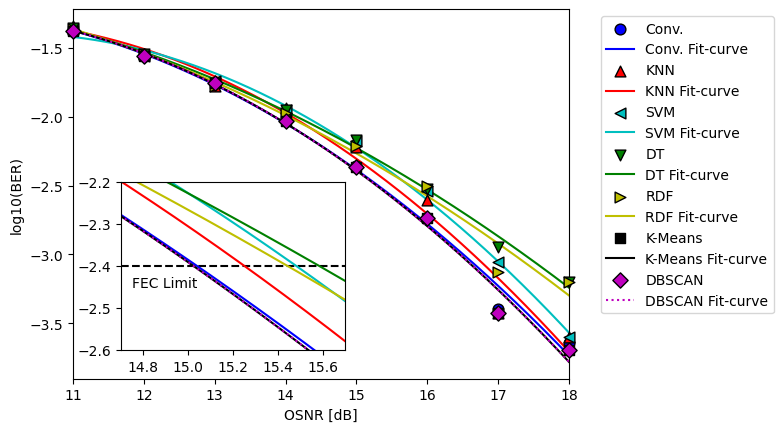

In [42]:
x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000)

fig, ax = plt.subplots()

ax.scatter(OSNR, np.log10(ber_conv), s=60, c='b', marker='o',
            edgecolors='black', label='Conv.', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_conv)), 'b-', label='Conv. Fit-curve')

ax.scatter(OSNR, np.log10(ber_knn), s=60, c='r', marker='^',
            edgecolors='black', label='KNN', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_knn)), 'r-', label='KNN Fit-curve')

ax.scatter(OSNR, np.log10(ber_svm), s=60, c='c', marker='<',
            edgecolors='black', label='SVM', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_svm)), 'c-', label='SVM Fit-curve')

ax.scatter(OSNR, np.log10(ber_tree), s=60, c='g', marker='v',
            edgecolors='black', label='DT', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_tree)), 'g-', label='DT Fit-curve')

ax.scatter(OSNR, np.log10(ber_rtree), s=60, c='y', marker='>',
            edgecolors='black', label='RDF', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_rtree)), 'y-', label='RDF Fit-curve')

ax.scatter(OSNR, np.log10(ber_kmeans), s=60, c='k', marker='s',
            edgecolors='black', label='K-Means', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_kmeans)), 'k-', label='K-Means Fit-curve')

ax.scatter(OSNR, np.log10(ber_dbscan), s=60, c='m', marker='D',
            edgecolors='black', label='DBSCAN', zorder=3, clip_on=False)
ax.plot(x_step, sm.polinomial_func(x_step, OSNR,
         np.log10(ber_dbscan)), 'm:', label='DBSCAN Fit-curve')

ax_zoom = plt.axes([0.2, 0.17, 0.35, 0.35])
ax_zoom.set_xlim(14.7, 15.7)
ax_zoom.set_ylim(-2.6, -2.2)
ax_zoom.hlines(-2.4, 14.7, 16, ls="--", color="black")
ax_zoom.text(x=14.75, y=-2.45, s="FEC Limit", fontsize=10)

ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_conv)), 'b-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_knn)), 'r-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_svm)), 'c-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_tree)), 'g-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_rtree)), 'y-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_kmeans)), 'k-')
ax_zoom.plot(x_step, sm.polinomial_func(x_step, OSNR, np.log10(ber_dbscan)), 'm:')

ax.set_xlabel('OSNR [dB]')
ax.set_ylabel('log10(BER)')
ax.set_xlim([np.min(OSNR), np.max(OSNR)])
ax.set_xticks(np.arange(np.min(OSNR), np.max(OSNR)+1, 1))
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()
